In [34]:
# System operations
import os

# type hinting
from typing import List, Mapping, Tuple

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Data manipulation
import math
import numpy as np
import pandas as pd
import random

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.agents.marlisa import MARLISA as RLAgent
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

### Load dataset

In [35]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

#### Preview a Building Data File

,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW]
0,7.0,24.0,7.0,0,NaN,NaN,NaN,2.275800,0,0,0,0.0
1,8.0,1.0,1.0,0,NaN,NaN,NaN,0.851167,0,0,0,0.0
2,8.0,2.0,1.0,0,NaN,NaN,NaN,0.834600,0,0,0,0.0
3,8.0,3.0,1.0,0,NaN,NaN,NaN,0.838167,0,0,0,0.0
4,8.0,4.0,1.0,0,NaN,NaN,NaN,1.478433,0,0,0,0.0


,Month,Hour,Day Type,Daylight Savings Status,Indoor Temperature [C],Average Unmet Cooling Setpoint Difference [C],Indoor Relative Humidity [%],Equipment Electric Power [kWh],DHW Heating [kWh],Cooling Load [kWh],Heating Load [kWh],Solar Generation [W/kW]
count,8760.000000,8760.000000,8760.000000,8760.0,0.0,0.0,0.0,8760.000000,8760.0,8760.0,8760.0,8760.000000
mean,6.526027,12.500000,3.992466,0.0,NaN,NaN,NaN,1.208145,0.0,0.0,0.0,205.836089
std,3.448048,6.922582,2.003522,0.0,NaN,NaN,NaN,0.968270,0.0,0.0,0.0,290.977786
min,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,0.057000,0.0,0.0,0.0,0.000000
25%,4.000000,6.750000,2.000000,0.0,NaN,NaN,NaN,0.570167,0.0,0.0,0.0,0.000000
50%,7.000000,12.500000,4.000000,0.0,NaN,NaN,NaN,0.812079,0.0,0.0,0.0,0.000000
75%,10.000000,18.250000,6.000000,0.0,NaN,NaN,NaN,1.530529,0.0,0.0,0.0,412.108333
max,12.000000,24.000000,7.000000,0.0,NaN,NaN,NaN,7.987483,0.0,0.0,0.0,976.250000


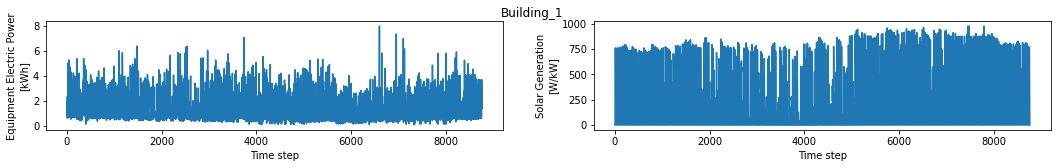

In [36]:
# Building data file
root_directory = schema['root_directory']

# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

display(building_data.describe(include='all'))

fig, axs = plt.subplots(1, 2, figsize=(18, 2))
x = building_data.index
y1 = building_data['Equipment Electric Power [kWh]']
y2 = building_data['Solar Generation [W/kW]']
axs[0].plot(x, y1)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Equipment Electric Power\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Solar Generation\n[W/kW]')
fig.suptitle(building_name)
plt.show()

#### Preview Weather File

,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


,Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],6h Prediction Outdoor Drybulb Temperature [C],12h Prediction Outdoor Drybulb Temperature [C],24h Prediction Outdoor Drybulb Temperature [C],6h Prediction Relative Humidity [%],12h Prediction Relative Humidity [%],24h Prediction Relative Humidity [%],6h Prediction Diffuse Solar Radiation [W/m2],12h Prediction Diffuse Solar Radiation [W/m2],24h Prediction Diffuse Solar Radiation [W/m2],6h Prediction Direct Solar Radiation [W/m2],12h Prediction Direct Solar Radiation [W/m2],24h Prediction Direct Solar Radiation [W/m2]
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,16.837454,73.004224,208.282192,201.231507,16.837454,16.837454,16.837454,73.004224,73.004224,73.004224,208.282192,208.282192,208.282192,201.231507,201.231507,201.231507
std,3.564816,16.480251,292.799407,296.193301,3.564816,3.564816,3.564816,16.480251,16.480251,16.480251,292.799407,292.799407,292.799407,296.193301,296.193301,296.193301
min,5.600000,10.000000,0.000000,0.000000,5.600000,5.600000,5.600000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.400000,65.000000,0.000000,0.000000,14.400000,14.400000,14.400000,65.000000,65.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.200000,76.000000,10.000000,0.000000,17.200000,17.200000,17.200000,76.000000,76.000000,76.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000
75%,19.400000,84.000000,382.000000,424.000000,19.400000,19.400000,19.400000,84.000000,84.000000,84.000000,382.000000,382.000000,382.000000,424.000000,424.000000,424.000000
max,32.200000,100.000000,1017.000000,953.000000,32.200000,32.200000,32.200000,100.000000,100.000000,100.000000,1017.000000,1017.000000,1017.000000,953.000000,953.000000,953.000000


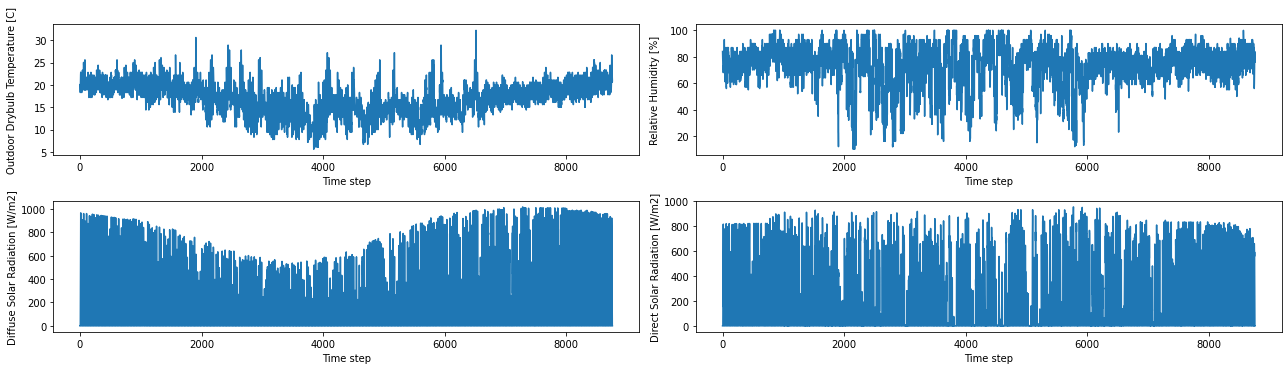

In [37]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())

display(weather_data.describe(include='all'))

columns = [
    'Outdoor Drybulb Temperature [C]', 'Relative Humidity [%]', 
    'Diffuse Solar Radiation [W/m2]', 'Direct Solar Radiation [W/m2]'
]
fig, axs = plt.subplots(2, 2, figsize=(18, 5))
x = weather_data.index

for ax, c in zip(fig.axes, columns):
    y = weather_data[c]
    ax.plot(x, y)
    ax.set_xlabel('Time step')
    ax.set_ylabel(c)

fig.align_ylabels()
plt.tight_layout()
plt.show()

#### Preview Electricity Price Data

In [38]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,Electricity Pricing [$],6h Prediction Electricity Pricing [$],12h Prediction Electricity Pricing [$],24h Prediction Electricity Pricing [$]
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


#### Preview Carbon Intensity Data

,kg_CO2/kWh
0,0.170724
1,0.157319
2,0.154503
3,0.150945
4,0.151820


,count,mean,std,min,25%,50%,75%,max
kg_CO2/kWh,8760.0,0.156531,0.03537,0.070383,0.13108,0.154263,0.178429,0.281796


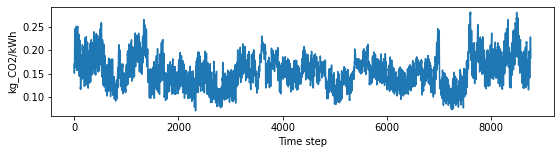

In [39]:
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
display(carbon_intensity_data.head())
display(carbon_intensity_data.describe(include='all').T)

fig, ax = plt.subplots(1, 1, figsize=(9, 2))
x = carbon_intensity_data.index
y = carbon_intensity_data['kg_CO2/kWh']
ax.plot(x, y)
ax.set_xlabel('Time step')
ax.set_ylabel('kg_CO2/kWh')
plt.show()

### Data Preprocessing

In [40]:
def set_schema_buildings(
schema: dict, count: int, seed: int
) -> Tuple[dict, List[str]]:
    """Randomly select number of buildings to set as active in the schema.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of buildings to set as active in schema.
    seed: int
        Seed for pseudo-random number generator

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active buildings set.
    buildings: List[str]
        List of selected buildings.
    """

    assert 1 <= count <= 15, 'Count must be between 1 and 15.'
    
    # set random seed
    np.random.seed(seed)

    # get all building names
    buildings = list(schema['buildings'].keys())

    # remove buildins 12 and 15 as they have pecularities in their data
    # that are not relevant to this tutorial
    buildings_to_exclude = ['Building_12', 'Building_15']

    for b in buildings_to_exclude:
        buildings.remove(b)

    # randomly select specified number of buildings
    buildings = np.random.choice(buildings, size=count, replace=False).tolist()

    # reorder buildings
    building_ids = [int(b.split('_')[-1]) for b in buildings]
    building_ids = sorted(building_ids)
    buildings = [f'Building_{i}' for i in building_ids]

    # update schema to only included selected buildings
    for b in schema['buildings']:
        if b in buildings:
            schema['buildings'][b]['include'] = True
        else:
            schema['buildings'][b]['include'] = False
        

    return schema, buildings

In [41]:
def set_schema_simulation_period(
    schema: dict, count: int, seed: int
) -> Tuple[dict, int, int]:
    """Randomly select environment simulation start and end time steps
    that cover a specified number of days.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    count: int
        Number of simulation days.
    seed: int
        Seed for pseudo-random number generator.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with `simulation_start_time_step` 
        and `simulation_end_time_step` key-values set.
    simulation_start_time_step: int
        The first time step in schema time series files to 
        be read when constructing the environment.
    simulation_end_time_step: int
        The last time step in schema time series files to 
        be read when constructing the environment.
    """

    assert 1 <= count <= 365, 'Count must be between 1 and 365.'

    # set random seed
    np.random.seed(seed)

    # use any of the files to determine the total 
    # number of available time steps
    filename = schema['buildings'][building_name]['carbon_intensity']
    filepath = os.path.join(root_directory, filename)
    time_steps = pd.read_csv(filepath).shape[0]

    # set candidate simulation start time steps 
    # spaced by the number of specified days
    simulation_start_time_step_list = np.arange(0, time_steps, 24*count)

    # randomly select a simulation start time step
    simulation_start_time_step = np.random.choice(
        simulation_start_time_step_list, size=1
    )[0]
    simulation_end_time_step = simulation_start_time_step + 24*count - 1

    # update schema simulation time steps
    schema['simulation_start_time_step'] = simulation_start_time_step
    schema['simulation_end_time_step'] = simulation_end_time_step

    return schema, simulation_start_time_step, simulation_end_time_step

In [42]:
def set_active_observations(
    schema: dict, active_observations: List[str]
) -> Tuple[dict, List[str]]:
    """Set the observations that will be part of the environment's 
    observation space that is provided to the control agent.

    Parameters
    ----------
    schema: dict
        CityLearn dataset mapping used to construct environment.
    active_observations: List[str]
        Names of observations to set active to be passed to control agent.

    Returns
    -------
    schema: dict
        CityLearn dataset mapping with active observations set.
    observations: List[str]
        List of active observations.
    """

    active_count = 0
    valid_observations = list(schema['observations'].keys())
    observations = []

    for o in schema['observations']:
        if o in active_observations:
            schema['observations'][o]['active'] = True
            observations.append(o)
            active_count += 1
        else:
            schema['observations'][o]['active'] = False

    assert active_count > 0,\
        'the provided observations are not valid observations.'\
          f' Valid observations in CityLearn are: {valid_observations}'
    
    return schema, observations

#### Set Random Seed

In [43]:
RANDOM_SEED = 0
print('Random seed:', RANDOM_SEED)

Random seed: 0


#### Setting the Buildings, Time Periods and Observations to use in Simulations from the Schema

In [44]:
# edit next code line to change number of buildings in simulation
building_count = 2

 # edit next code line to change number of days in simulation
day_count = 7

# edit next code line to change active observations in simulation
active_observations = ['hour']

schema, buildings = set_schema_buildings(schema, building_count, RANDOM_SEED)
schema, simulation_start_time_step, simulation_end_time_step =\
    set_schema_simulation_period(schema, day_count, RANDOM_SEED)
schema, active_observations =\
    set_active_observations(schema, active_observations)

print('Selected buildings:', buildings)
print(
    f'Selected {day_count}-day period time steps:', 
    (simulation_start_time_step, simulation_end_time_step)
)
print(f'Active observations:', active_observations)

Selected buildings: ['Building_2', 'Building_7']
Selected 7-day period time steps: (7392, 7559)
Active observations: ['hour']


#### Central Agent?

In [45]:
schema['central_agent'] = False

### Initialize a CityLearn Environment

In [72]:
env = CityLearnEnv(schema)

print('Current time step:', env.time_step)
print('environment number of time steps:', env.time_steps)
print('environment uses central agent:', env.central_agent)
print('Common (shared) observations amogst buildings:', env.shared_observations)
print('Number of buildings:', len(env.buildings))

# electrical storage
print('Electrical storage capacity:', {
    b.name: b.electrical_storage.capacity for b in env.buildings
})
print('Electrical storage nominal power:', {
    b.name: b.electrical_storage.nominal_power for b in env.buildings
})
print('Electrical storage capacity history:', {
    b.name: b.electrical_storage.capacity_history for b in env.buildings
})
print('Electrical storage loss_coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print('Electrical storage initial_soc:', {
    b.name: b.electrical_storage.initial_soc for b in env.buildings
})
print('Electrical storage soc:', {
    b.name: b.electrical_storage.soc for b in env.buildings
})
print('Electrical storage efficiency:', {
    b.name: b.electrical_storage.efficiency for b in env.buildings
})
print('Electrical storage efficiency history:', {
    b.name: b.electrical_storage.efficiency_history for b in env.buildings
})
print('Electrical storage electricity consumption:', {
    b.name: b.electrical_storage.electricity_consumption 
    for b in env.buildings
})
print('Electrical storage capacity loss coefficient:', {
    b.name: b.electrical_storage.loss_coefficient for b in env.buildings
})
print()
# pv
print('PV nominal power:', {
    b.name: b.pv.nominal_power for b in env.buildings
})
print()

# active observations and actions
with pd.option_context(
    'display.max_rows', None, 
    'display.max_columns', None, 
    'display.width', None
):
    print('Active observations:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.observation_metadata} 
        for b in env.buildings
    ]))
    print()
    print('Active actions:')
    display(pd.DataFrame([
        {**{'building':b.name}, **b.action_metadata} 
        for b in env.buildings
    ]))

Current time step: 0
environment number of time steps: 168
environment uses central agent: False
Common (shared) observations amogst buildings: ['hour']
Number of buildings: 2
Electrical storage capacity: {'Building_2': 6.4, 'Building_7': 6.4}
Electrical storage nominal power: {'Building_2': 5.0, 'Building_7': 5.0}
Electrical storage capacity history: {'Building_2': [6.4], 'Building_7': [6.4]}
Electrical storage loss_coefficient: {'Building_2': 0.0, 'Building_7': 0.0}
Electrical storage initial_soc: {'Building_2': 0, 'Building_7': 0}
Electrical storage soc: {'Building_2': [0], 'Building_7': [0]}
Electrical storage efficiency: {'Building_2': 0.9, 'Building_7': 0.9}
Electrical storage efficiency history: {'Building_2': [0.9], 'Building_7': [0.9]}
Electrical storage electricity consumption: {'Building_2': [0.0], 'Building_7': [0.0]}
Electrical storage capacity loss coefficient: {'Building_2': 0.0, 'Building_7': 0.0}

PV nominal power: {'Building_2': 4.0, 'Building_7': 4.0}

Active observa

,building,hour
0,Building_2,True
1,Building_7,True



Active actions:


,building,electrical_storage
0,Building_2,True
1,Building_7,True


### Convenience Functions to Display Simulation Results

In [73]:
def get_kpis(env: CityLearnEnv) -> pd.DataFrame:
    """Returns evaluation KPIs.

    Electricity consumption, cost and carbon emissions KPIs are provided
    at the building-level and average district-level. Average daily peak,
    ramping and (1 - load factor) KPIs are provided at the district level.

    Parameters
    ----------
    env: CityLearnEnv
        CityLearn environment instance.

    Returns
    -------
    kpis: pd.DataFrame
        KPI table.
    """

    kpis = env.evaluate()

    # names of KPIs to retrieve from evaluate function
    kpi_names = [
        'electricity_consumption', 'cost', 'carbon_emissions', 
        'average_daily_peak', 'ramping', '1 - load_factor'
    ]
    kpis = kpis[
        (kpis['cost_function'].isin(kpi_names))
    ].dropna()

    # round up the values to 3 decimal places for readability
    kpis['value'] = kpis['value'].round(3)
    
    # rename the column that defines the KPIs
    kpis = kpis.rename(columns={'cost_function': 'kpi'})

    return kpis

In [74]:
def plot_building_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost and carbon emissions 
    at the building-level for different control agents in bar charts.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments 
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='building'].copy()
        kpis['building_id'] = kpis['name'].str.split('_', expand=True)[1]
        kpis['building_id'] = kpis['building_id'].astype(int).astype(str)
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    kpi_names= kpis['kpi'].unique()
    column_count_limit = 3
    row_count = math.ceil(len(kpi_names)/column_count_limit)
    column_count = min(column_count_limit, len(kpi_names))
    building_count = len(kpis['name'].unique())
    env_count = len(envs)
    figsize = (3.0*column_count, 0.3*env_count*building_count*row_count)
    fig, _ = plt.subplots(
        row_count, column_count, figsize=figsize, sharey=True
    )

    for i, (ax, (k, k_data)) in enumerate(zip(fig.axes, kpis.groupby('kpi'))):
        sns.barplot(x='value', y='name', data=k_data, hue='env_id', ax=ax)
        ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(k)

        if i == len(kpi_names) - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)

        for s in ['right','top']:
            ax.spines[s].set_visible(False)

        for p in ax.patches:
            ax.text(
                p.get_x() + p.get_width(), 
                p.get_y() + p.get_height()/2.0, 
                p.get_width(), ha='left', va='center'
            )
    
    plt.tight_layout()
    return fig

In [75]:
def plot_district_kpis(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots electricity consumption, cost, carbon emissions,
    average daily peak, ramping and (1 - load factor) at the 
    district-level for different control agents in a bar chart.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    kpis_list = []

    for k, v in envs.items():
        kpis = get_kpis(v)
        kpis = kpis[kpis['level']=='district'].copy()
        kpis['env_id'] = k
        kpis_list.append(kpis)

    kpis = pd.concat(kpis_list, ignore_index=True, sort=False)
    row_count = 1
    column_count = 1
    env_count = len(envs)
    kpi_count = len(kpis['kpi'].unique())
    figsize = (6.0*column_count, 0.225*env_count*kpi_count*row_count)
    fig, ax = plt.subplots(row_count, column_count, figsize=figsize)
    sns.barplot(x='value', y='kpi', data=kpis, hue='env_id', ax=ax)
    ax.axvline(1.0, color='black', linestyle='--', label='Baseline')
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    for p in ax.patches:
        ax.text(
            p.get_x() + p.get_width(), 
            p.get_y() + p.get_height()/2.0, 
            p.get_width(), ha='left', va='center'
        )

    ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
    plt.tight_layout()

    return fig

In [76]:
def plot_building_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level net electricty consumption profile 
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments 
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            y = v.buildings[i].net_electricity_consumption
            x = range(len(y))
            ax.plot(x, y, label=k)

        y = v.buildings[i].net_electricity_consumption_without_storage
        ax.plot(x, y, label='Baseline')
        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('kWh')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))

        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)
        
    
    plt.tight_layout()

    return fig

In [77]:
def plot_district_load_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots district-level net electricty consumption profile 
    for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments 
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    figsize = (5.0, 1.5)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for k, v in envs.items():
        y = v.net_electricity_consumption
        x = range(len(y))
        ax.plot(x, y, label=k)
    
    y = v.net_electricity_consumption_without_storage
    ax.plot(x, y, label='Baseline')
    ax.set_xlabel('Time step')
    ax.set_ylabel('kWh')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0)
    
    plt.tight_layout()
    return fig

In [78]:
def plot_battery_soc_profiles(envs: Mapping[str, CityLearnEnv]) -> plt.Figure:
    """Plots building-level battery SoC profiles fro different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments 
        the agents have been used to control.

    Returns
    -------
    fig: plt.Figure
        Figure containing plotted axes.
    """

    building_count = len(list(envs.values())[0].buildings)
    column_count_limit = 4
    row_count = math.ceil(building_count/column_count_limit)
    column_count = min(column_count_limit, building_count)
    figsize = (4.0*column_count, 1.75*row_count)
    fig, _ = plt.subplots(row_count, column_count, figsize=figsize)

    for i, ax in enumerate(fig.axes):
        for k, v in envs.items():
            soc = np.array(v.buildings[i].electrical_storage.soc)
            capacity = v.buildings[i].electrical_storage.capacity_history[0]
            y = soc/capacity
            x = range(len(y))
            ax.plot(x, y, label=k)

        ax.set_title(v.buildings[i].name)
        ax.set_xlabel('Time step')
        ax.set_ylabel('SoC')
        ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
        
        if i == building_count - 1:
            ax.legend(
                loc='upper left', bbox_to_anchor=(1.0, 1.0), framealpha=0.0
            )
        else:
            ax.legend().set_visible(False)
        
    
    plt.tight_layout()
    
    return fig

In [79]:
def plot_simulation_summary(envs: Mapping[str, CityLearnEnv]):
    """Plots KPIs, load and battery SoC profiles for different control agents.

    Parameters
    ----------
    envs: Mapping[str, CityLearnEnv]
        Mapping of user-defined control agent names to environments 
        the agents have been used to control.
    """
    
    _ = plot_building_kpis(envs)
    print('Building-level KPIs:')
    plt.show()
    _ = plot_building_load_profiles(envs)
    print('Building-level load profiles:')
    plt.show()
    _ = plot_battery_soc_profiles(envs)
    print('Battery SoC profiles:')
    plt.show()
    _ = plot_district_kpis(envs)
    print('District-level KPIs:')
    plt.show()
    print('District-level load profiles:')
    _ = plot_district_load_profiles(envs)
    plt.show()

### Optimize a Decentralized-Cooperative MARLISA Controller

In [85]:
marlisa_model = RLAgent(env)

# ----------------- CALCULATE NUMBER OF TRAINING EPISODES -----------------
marlisa_episodes = 2
print('Number of episodes to train:', marlisa_episodes)

# ------------------------------- TRAIN MODEL -----------------------------
#marlisa_model.learn(episodes=marlisa_episodes, deterministic_finish=True)

dataset_name = 'citylearn_challenge_2022_phase_1'
env = CityLearnEnv(dataset_name)
model = RLAgent(env)
model.learn(episodes=2, deterministic_finish=True)

Number of episodes to train: 2


In [66]:
observations = env.reset()
marlisa_actions_list = []

while not env.done:
    actions, _ = marlisa_model.predict(observations, deterministic=True)
    observations, _, _, _ = marlisa_env.step(actions)
    marlisa_actions_list.append(actions)

plot_simulation_summary(
    {'MARLISA': env}
)

fig = plot_actions(sacr_actions_list, 'SAC Actions using Custom Reward')
plt.show()

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'